# "MORE Plot for hospital reception simulation"
- Louis Luangkesorn <lluangkesorn@pitt.edu>
- 8/11/2019

This introduces the Measure of Risk and Error (MORE) plot [Nelson08] of simulation output which simultaneously shows the analyst a sense of the risk, expressed as a histogram along with the mean, the 0.05 quantile, and the 0.95 quantile), and a sense of the error of the simulation output (expressed as 95% C.I. for the mean, the 0.05 quantile, and the 0.95 quantile).

This example uses a hospital receptionist simulation orginally found in [Nelson13]. The implementation of the simulation uses the Simmer library in R [simmer19]


Nelson08: Nelson, B., (2008), THE MORE PLOT: DISPLAYING MEASURES OF RISK & ERROR FROM SIMULATION OUTPUT, 2008 Winter Simulation Conference, https://www.informs-sim.org/wsc08papers/048.pdf

Nelson13: Nelson, B., (2013), Foundations and Methods of Stochastic Simulation, Springer, http://users.iems.northwestern.edu/~nelsonb/IEMS435/

simmer19: Ucar I, Smeets B, Azcorra A (2019). “simmer: Discrete-Event Simulation for R.” Journal of Statistical Software, 90(2), 1–30. doi: 10.18637/jss.v090.i02. https://www.jstatsoft.org/article/view/v090i02/0 https://r-simmer.org/

In [1]:
library(ggplot2)
library(dplyr)
library(magrittr)
library(simmer)


Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Attaching package: 'simmer'

The following object is masked from 'package:dplyr':

    select



# Hospital simulation code

In [2]:
# Global constants
G <- list(RANDOM_SEED = 42,
          INTERVAL_patientS = 10.0, # Generate new patients roughly every x seconds
          maxTime = 8 * 60,          # minutes
          timeReceptionist = 0.8,   # mean, minutes
          phases = 3,
          ARRint = 1.0             # mean, minutes
)

In [3]:
# Visitor trajectory
visitor <- trajectory("Arriving visitor") %>%
  seize("receptionist", amount=1) %>%
  timeout(function () rgamma(n=1, 
                             scale=G[['timeReceptionist']]/G[['phases']], 
                             shape = G[['phases']])
  ) %>%
  release("receptionist", amount=1)

In [4]:
# Main Simulation code
reps = 10
set.seed(G[['RANDOM_SEED']])
envs <- lapply(1:reps, function(i) {
                simmer("HospitalDES") %>%
                add_resource("receptionist", 1) %>%
                add_generator("visitor", visitor, 
                              function() rexp(n=1,rate = (1/G[['ARRint']]))) %>%
                run(until=G[['maxTime']])
})


In [5]:
# Collect statistics with monitors
receptionmonitor <- lapply(1:reps, function(i){
  result <- envs[[i]] %>% 
  get_mon_resources()
})
patientmonitor <- lapply(1:reps, function(i){
        result <- envs[[i]] %>% 
        get_mon_arrivals %>%
        mutate(flow_time = end_time - start_time)
      }
)
# Note that the result of lapply on the simmer output is a list of dataframes

# Measures of Risk and Error

##  Risk vs. Error
-  *Measures of risk*
	-  Directly support decision making.
	-  What is the range of outcomes that can occur and their probabilities if the system is designed in a specific way.
		-  If $F_Y(5)$ (probability of completing a project in 5 days) is too small, we may decide not to undertake the project as designed.
-  *Measures of error*
	-  Directly support experiment design
	-  Did we expend enough simulation effort (e.g. replications) to be confident in our estimates of system performance
	
##  Measure of Risk and Error (MORE) Plot

-  Measures of error.   The C.I. on the average or the quantiles are measure of error.
    -  As a simulation analyst we can reduce error (how?)
    -  How to choose which performance measure's C.I. we should use in specifying error.
    -  What does the C.I. on these statistics (average, quantile) tell us about our system and experimental design?
-  Measures of risk
    -  How can we as engineers reduce risk?
    -  How do we measure risk?  What do these types of statistics actually tell us about our system and experimental design?
    
## Creating a MORE plot

-  Start with a histogram.
-  Add the sample average and 0.05 and 0.95 quantiles.
-  This range is considered *likely*, beyond that is considered *unlikely*.
	-  Measure of *risk*
-  Include 95% C.I. for the average and both quantiles.
	-  Measure of *error* at the center and the extremes of the range of outcomes.
-  Goal:  to represent both risk and error in an intuitively understandable way.

In [6]:
# Creating MORE plot

require(foreach)
require(ggplot2)

moreplot <- function(simoutput, dataelement){
  # Measure of Risk and Error (MORE) plot from Nelson, et. al.
  # Generate histogram using all of the simulation data from all replications
  # Add vertical lines with mean and 5% and 95% quantile and error bars for confidence intervals from the replications
  # INPUTS: 
  # - simoutput: list of dataframes of simmer monitor output from simulation model replications
  # - dataelement:  quoted name of column with performance data to be plotted
  # OUTPUT: 
  # creates a MORE plot with histogram of performance measure, mean, and 0.05 and 0.95 quantiles with 95% confidence intervals
  # EXAMPLE OF USE: 
  # moreplot(patientmonitor, flow_time)

  reps <- length(simoutput)
  allpatients <- bind_rows(simoutput)
  dataindex <- which(colnames(allpatients)==dataelement)
  # get mean and averages for mean and the 5% and 95% quantiles 
  getquantiles <- function(datavector){
    mean <- mean(datavector)
    quantiles <- quantile(datavector, probs=c(0.05, 0.95))
    return(c(mean, quantiles[[1]], quantiles[[2]]))
  }
  
  # get mean and quantiles for each replication, 
  # then calculate the mean and C.I. for the mean and both quantiles
  
  samplestats <- foreach(i=1:length(simoutput)) %do% getquantiles(simoutput[[i]][[dataelement]])  
  samplestatsdf <- as.data.frame(t(as.data.frame(lapply(samplestats, as.data.frame))))
  names(samplestatsdf) <- c('mean', 'q05', 'q95')
  
  # create a data frame for the ci of each statistic for use in the ggplot to follow
  meanstats <- data.frame(mean = mean(samplestatsdf$mean),
                          lowerci = qt(0.05,reps) * sd(samplestatsdf$mean)/length(samplestatsdf$mean) + 
                                      mean(samplestatsdf$mean),
                          upperci = qt(0.95, reps) * sd(samplestatsdf$mean)/length(samplestatsdf$mean) + 
                                      mean(samplestatsdf$mean))
  q05stats <- data.frame(mean = mean(samplestatsdf$q05),
                         lowerci = qt(0.05, reps) * sd(samplestatsdf$q05)/length(samplestatsdf$q05) + 
                                    mean(samplestatsdf$q05),
                         upperci = qt(0.95, reps) * sd(samplestatsdf$q05)/length(samplestatsdf$q05) + 
                                    mean(samplestatsdf$q05))  
  q95stats <- data.frame(mean = mean(samplestatsdf$q95),
                         lowerci = qt(0.05, reps) * sd(samplestatsdf$q95)/length(samplestatsdf$q95) + 
                                     mean(samplestatsdf$q95),
                         upperci = qt(0.95, reps) * sd(samplestatsdf$q95)/length(samplestatsdf$q95) + 
                                     mean(samplestatsdf$q95))
  # Generate base histogram
  flowplot <- ggplot(allpatients) +
    geom_histogram(aes(x=flow_time, y=..density..)) +
    ggtitle("Measure of risk and error plot") +
    xlab(paste(dataelement, "(q05, mean, q95)"))
  ggp_build <- ggplot_build(flowplot)
  maxdensity <- max(ggp_build[["data"]][[1]][["density"]])
  # Add vertical lines for mean, q05, q95, along with the C.I. error bars
  flowplot <- flowplot +
    geom_segment(data = meanstats, aes(x = mean, y = 0, xend = mean, yend = (ceiling(maxdensity*100)/100))) +
    geom_segment(data = q05stats, aes(x = mean, y = 0, xend = mean, yend = (ceiling(maxdensity*100)/100))) +
    geom_segment(data = q95stats, aes(x = mean, y = 0, xend = mean, yend = (ceiling(maxdensity*100)/100))) +
    geom_errorbarh(data = meanstats, aes(xmax = upperci, xmin = lowerci, 
                                         y = -0.01, height = 0.01)) +
    geom_errorbarh(data = q05stats, aes(xmax = upperci, xmin = lowerci, 
                                        y = -0.01, height = 0.01)) +
    geom_errorbarh(data = q95stats, aes(xmax = upperci, xmin = lowerci, 
                                        y = -0.01, height = 0.01)) +
    annotate("text", label = "C.I. mean", x = meanstats$mean, y = -0.02) +
    annotate("text", label = "C.I. Q0.05", x = q05stats$mean, y = -0.02) +
    annotate("text", label = "C.I. Q0.95", x = q95stats$mean, y = -0.02)
  flowplot
}

Loading required package: foreach


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


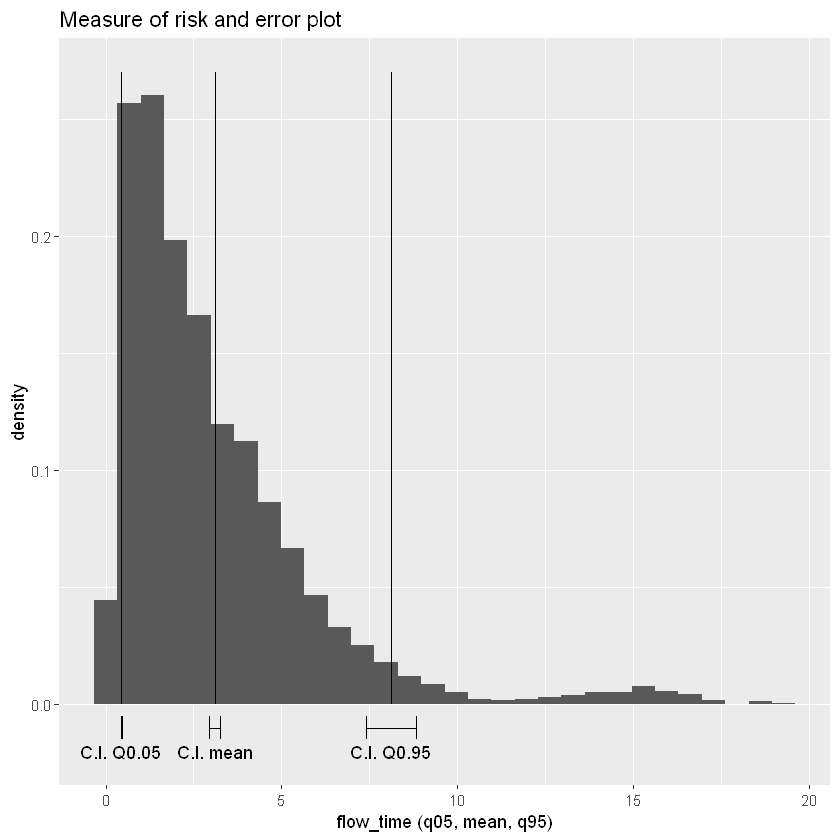

In [7]:
flowmore <- moreplot(patientmonitor, "flow_time")
flowmore

In this MORE plot, the solid lines are the mean and 0.05 and 0.95 quantiles. This provides a measure of the risk, what is the range of values that will generally be experienced by entities in this system (visitors to a hospital going to the information desk).  The error bars below the x axis provide measures of the error, which are the confidence intervals of the estimate of the mean, the 0.05 quantile, and the 0.95 quantile.  Note that the measure of error is not the same for each of the three.  Depending on what performance measure is most useful for the system, the analyst would then decide how many replications would be needed to reduce that particular performance measure's C.I. to an acceptable level.